----------------------------  Processing 十五舍  ----------------------------
Preprocessing 十五舍 data......
Reading 十五舍 data......
Reading 十五舍 data finished!


Dispatching 十五舍: 100%|██████████| 84/84 [00:02<00:00, 37.96it/s]


Preprocessing 十五舍 data finished!


d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33293 (\N{CJK UNIFIED IDEOGRAPH-820D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


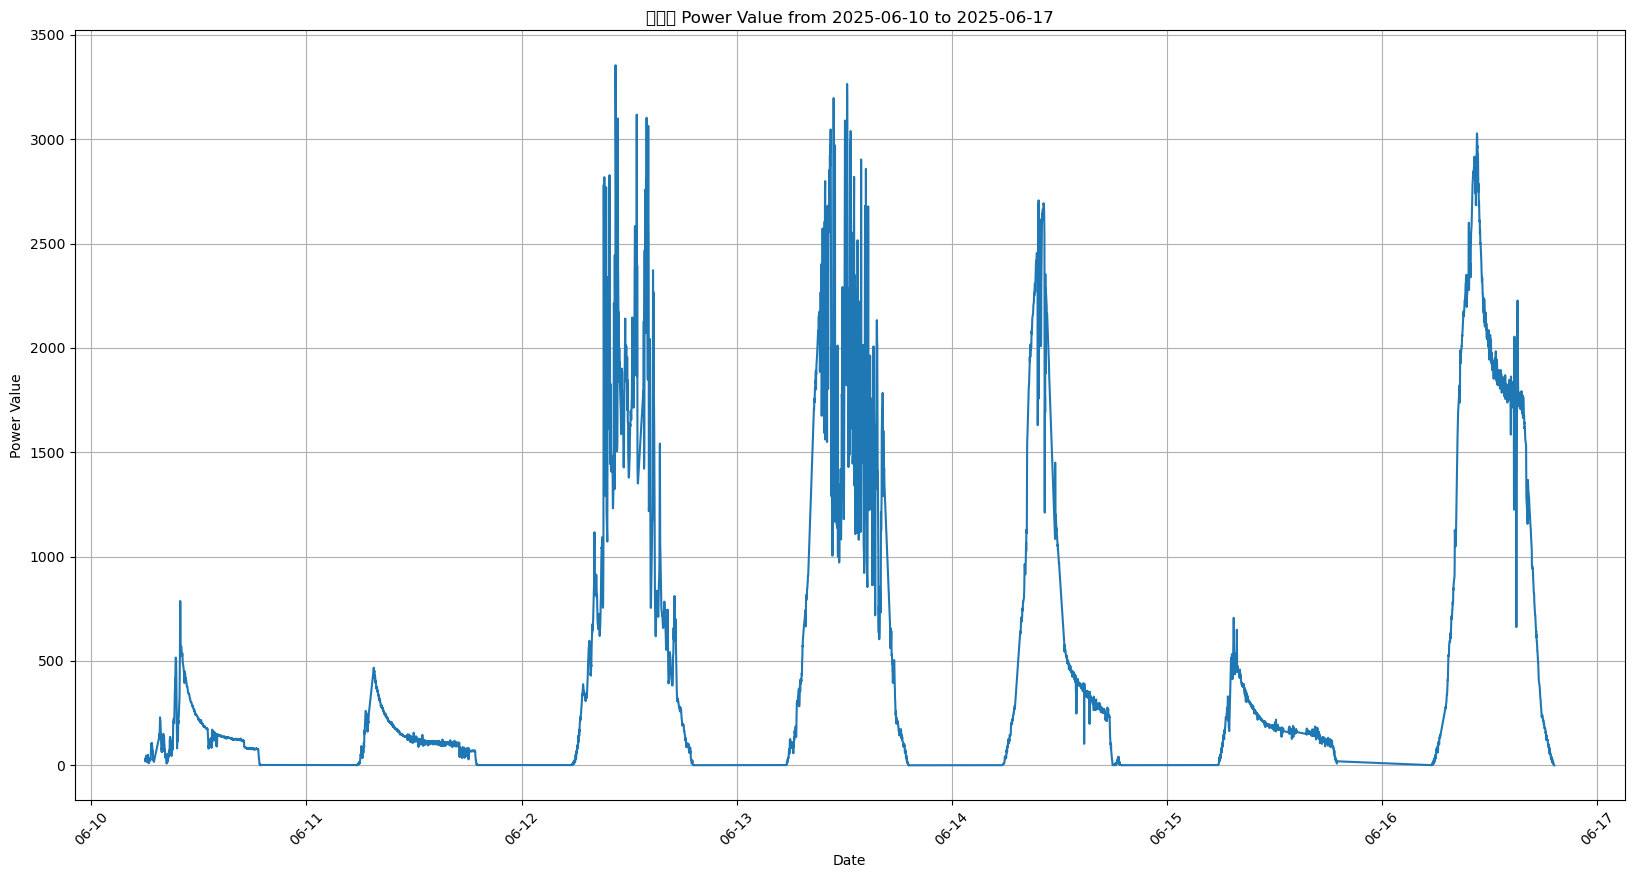

d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20116 (\N{CJK UNIFIED IDEOGRAPH-4E94}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33293 (\N{CJK UNIFIED IDEOGRAPH-820D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


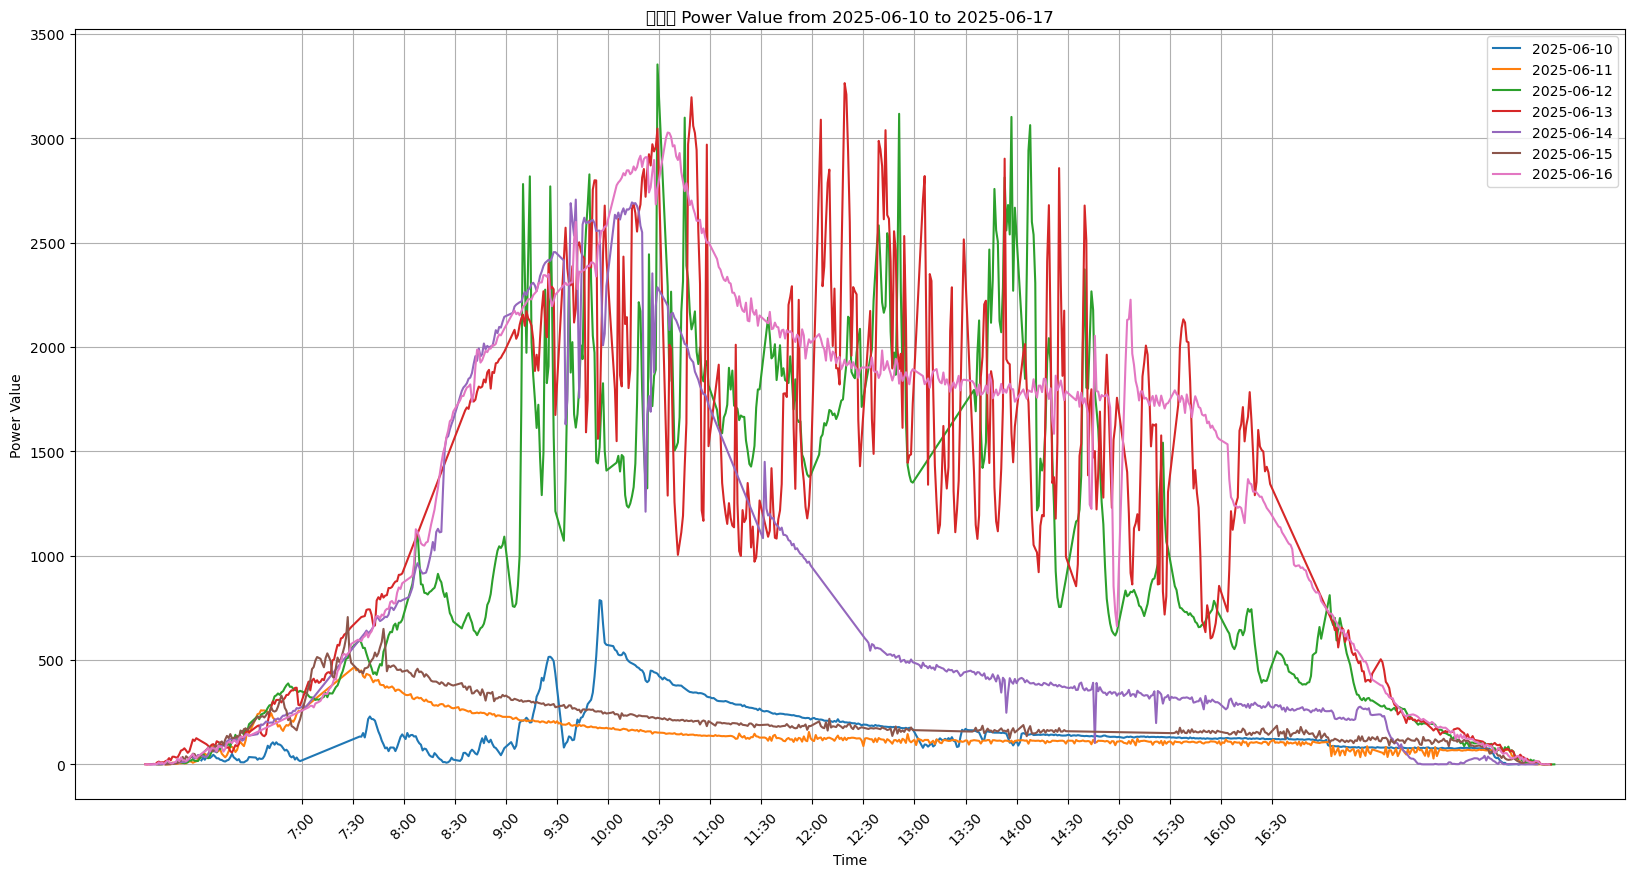

----------------------------  Processing 专教  ----------------------------
Preprocessing 专教 data......
Reading 专教 data......
Reading 专教 data finished!


Dispatching 专教: 100%|██████████| 90/90 [00:02<00:00, 31.55it/s]


Preprocessing 专教 data finished!


d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19987 (\N{CJK UNIFIED IDEOGRAPH-4E13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25945 (\N{CJK UNIFIED IDEOGRAPH-6559}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


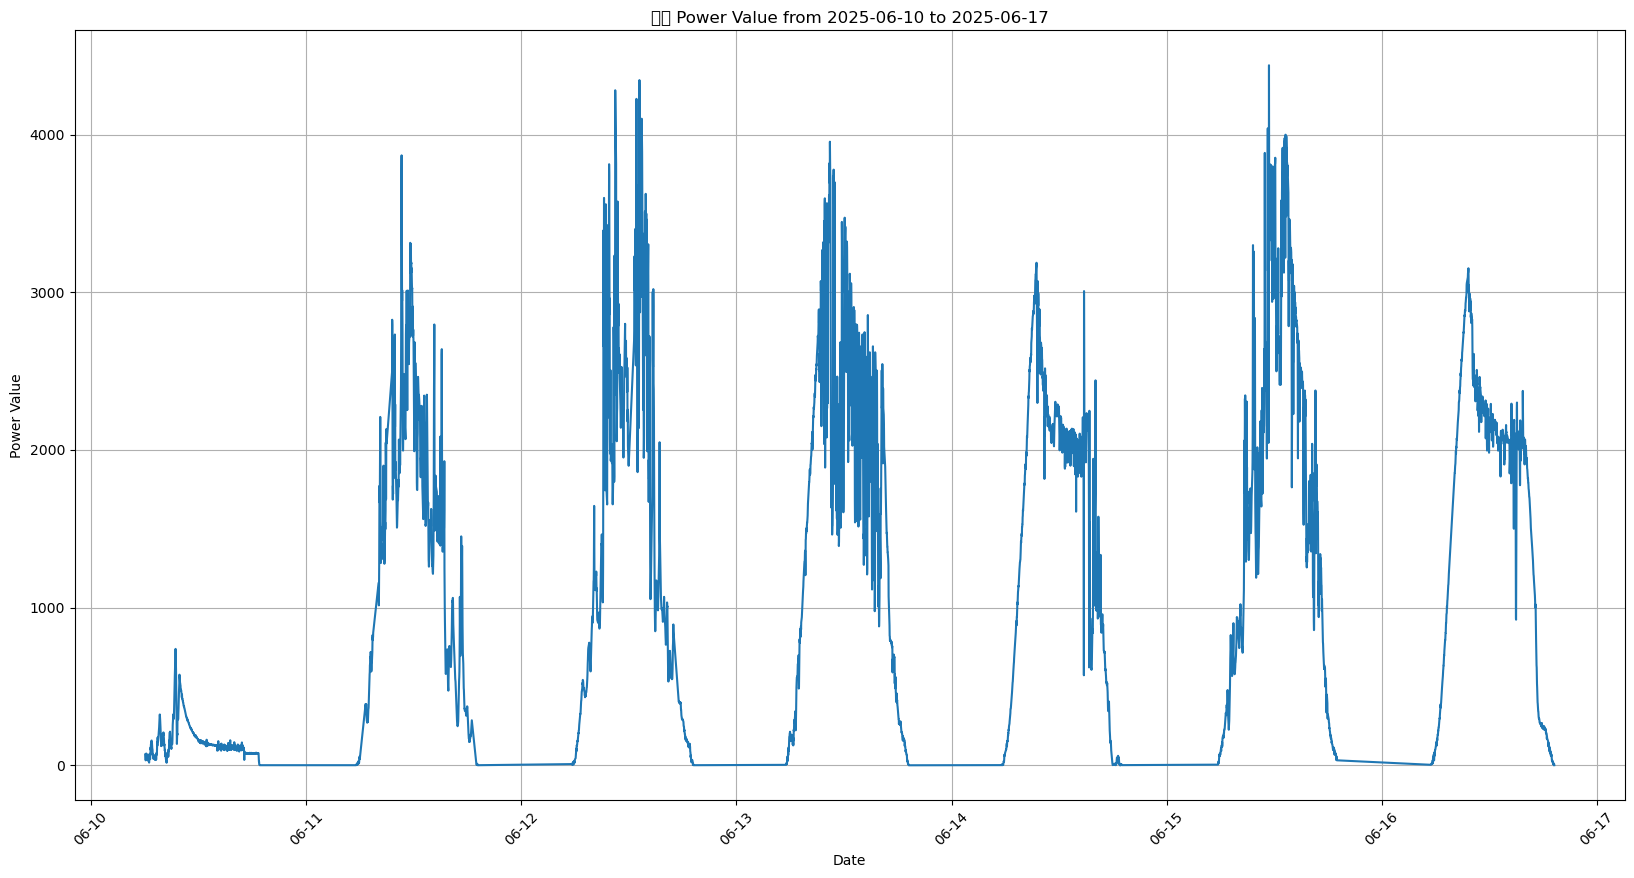

d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19987 (\N{CJK UNIFIED IDEOGRAPH-4E13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25945 (\N{CJK UNIFIED IDEOGRAPH-6559}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


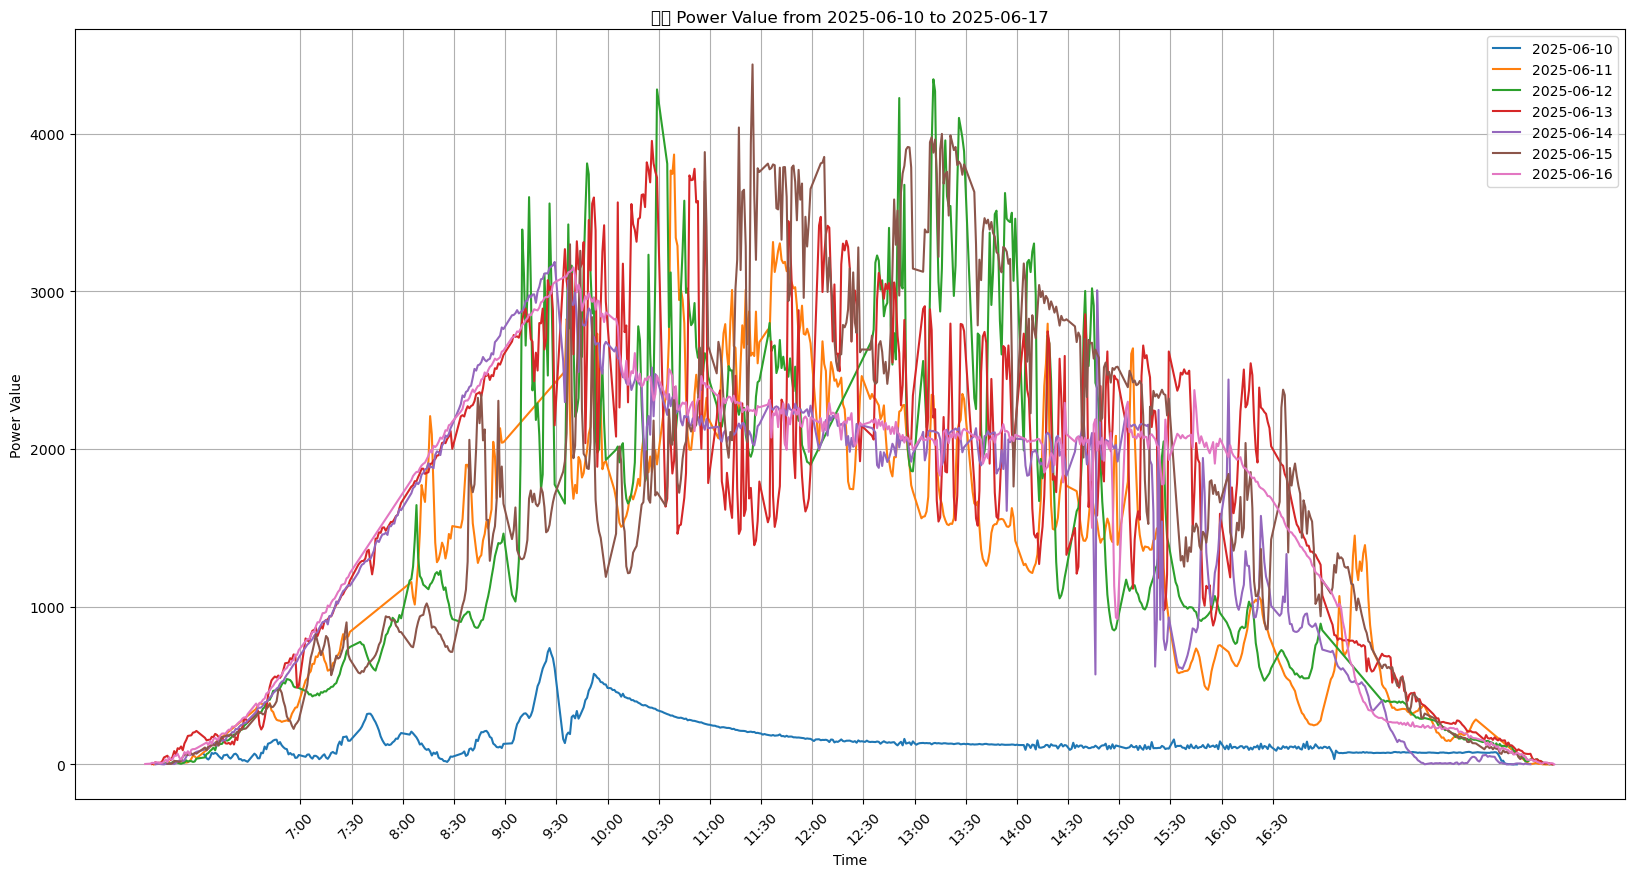

In [ ]:
import os
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def preprocess_data(pre_fix, extracted_raw_data_dir, filtered_data_dir):
    """
    预处理原始数据，读取指定目录下的所有Excel文件，处理时间偏移，
    并按照日期对数据进行分组保存。
    
    参数:
        pre_fix (str): 数据前缀标识，用于日志输出
        extracted_raw_data_dir (str): 原始Excel文件所在目录路径
        filtered_data_dir (str): 处理后数据保存目录路径
        
    处理步骤:
        1. 读取所有.xlsx文件
        2. 修正eventTime列的时间偏移(+8小时)
        3. 将时间精确到分钟，合并相同时间点的数据
        4. 按日期分组，每组保存为单独的Excel文件
    """

    # 读取所有 .xlsx 文件并处理
    excel_files = [f for f in os.listdir(extracted_raw_data_dir) if f.endswith('.xlsx')]   
    raw_df = pd.DataFrame()
    print (f"Reading {pre_fix} data......")
    # 更正 eventTime 列的时间偏移+8小时， eventTime 的格式为 "%Y-%m-%d %H:%M:%S" ，例如2025-03-10 03:29:33， 加了8小时如果超过24小时，日期也要加1天
    for file in excel_files:
        file_path = os.path.join(extracted_raw_data_dir, file)
        df = pd.read_excel(file_path)
        df['eventTime'] = pd.to_datetime(df['eventTime']) + pd.Timedelta(hours=8)
        # 将时间精确到分钟，去掉秒
        df['eventTime'] = df['eventTime'].dt.strftime('%Y-%m-%d %H:%M')
        # 查重，相同的分钟取平均值
        df = df.groupby('eventTime').mean().reset_index()
        raw_df = pd.concat([raw_df, df], ignore_index=True)

    print (f"Reading {pre_fix} data finished!")

    # 确保 eventTime 列是 datetime 类型
    raw_df['eventTime'] = pd.to_datetime(raw_df['eventTime'], errors='coerce')
    # 查重，删除重复eventTime的行
    raw_df = raw_df.drop_duplicates(subset=['eventTime'])
    # 按照 eventTime 中的日期分组，每组数据保存为一个新的 Excel 文件
    for name, group in tqdm(raw_df.groupby(raw_df['eventTime'].dt.date), desc=f"Dispatching {pre_fix}"):
        file_name = os.path.join(filtered_data_dir, f"{name}.xlsx")
        group = group.sort_values(by='eventTime')
        # group.to_csv(file_name, index=False, encoding='utf-8-sig')

        # 使用 ExcelWriter 指定 utf-8-sig 编码
        with pd.ExcelWriter(file_name, engine='openpyxl', mode='w') as writer:
            group.to_excel(writer, index=False)


def visualize_data(filtered_data_dir, pre_fix, visual_start_time, visual_end_time):
    """
    可视化指定时间范围内的数据，生成两种不同的图表展示功率值变化。
    
    参数:
        filtered_data_dir (str): 处理后的数据文件所在目录
        pre_fix (str): 数据前缀标识，用于图表标题
        visual_start_time (str): 可视化开始时间，格式为'YYYY-MM-DD'
        visual_end_time (str): 可视化结束时间，格式为'YYYY-MM-DD'
        
    生成图表:
        1. 图1：按照时间顺序展示功率值的变化趋势，x轴为日期时间，y轴为功率值
        2. 图2：按照每天的时间点展示不同日期的功率值对比，x轴为一天中的时间，y轴为功率值
    """
    # 可视化 visual_start_time 到 visual_end_time 之间的数据
    visual_df = pd.DataFrame()
    for file in os.listdir(filtered_data_dir):
        file_path = os.path.join(filtered_data_dir, file)
        df = pd.read_excel(file_path)
        visual_df = pd.concat([visual_df, df], ignore_index=True)
    visual_df['eventTime'] = pd.to_datetime(visual_df['eventTime'])
    visual_df = visual_df[(visual_df['eventTime'] >= visual_start_time) & (visual_df['eventTime'] <= visual_end_time)]
    
    # 图1：x轴为不同的日期，y轴为功率值
    visual_df['date'] = visual_df['eventTime'].dt.date
    visual_df = visual_df.sort_values(by='eventTime')

    ## 绘制折线图1
    plt.figure(figsize=(20, 10))
    plt.plot(visual_df['eventTime'], visual_df['value'])
    plt.xlabel('Date')
    plt.ylabel('Power Value')
    plt.title(f'{pre_fix} Power Value from {visual_start_time} to {visual_end_time}')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.grid()
    plt.show()

    # 图2：x轴为不同的日期+相同的时间，y轴为功率值
    visual_df['time'] = visual_df['eventTime'].dt.time
    # 将time对象转换为小时数的浮点数表示，以便matplotlib可以处理
    visual_df['time_float'] = visual_df['eventTime'].apply(lambda x: x.hour + x.minute/60)
    visual_df = visual_df.sort_values(by=['date', 'time'])

    ## 绘制折线图2
    plt.figure(figsize=(20, 10))
    for date, group in visual_df.groupby('date'):
        plt.plot(group['time_float'], group['value'], label=str(date))
    
    plt.xlabel('Time')
    plt.ylabel('Power Value')
    plt.title(f'{pre_fix} Power Value from {visual_start_time} to {visual_end_time}')
    
    # 设置x轴刻度为30分钟间隔，从7:00到17:00
    time_ticks = [i + j/60 for i in range(7, 17) for j in [0, 30]]
    time_labels = [f"{int(t)}:{int((t-int(t))*60):02d}" for t in time_ticks]
    plt.xticks(time_ticks, time_labels, rotation=45)
    
    plt.legend()
    plt.grid()
    plt.show()



def main(pre_fix, extracted_dir):
    """
    主函数，协调数据预处理和可视化的整体流程。
    
    参数:
        pre_fix (str): 数据前缀标识，用于定位数据目录和日志输出
        extracted_dir (str): 提取的数据根目录路径
        
    处理流程:
        1. 构建原始数据和处理后数据的目录路径
        2. 创建必要的目录结构
        3. 调用预处理函数处理数据
        4. 调用可视化函数展示指定时间段的数据
    """
    extracted_raw_data_dir = os.path.join(extracted_dir, pre_fix)
    filtered_data_dir = os.path.join(extracted_dir, pre_fix, "filtered")
    if not os.path.exists(filtered_data_dir):
        os.makedirs(filtered_data_dir)

    # 预处理数据
    print (f"Preprocessing {pre_fix} data......")
    preprocess_data(pre_fix, extracted_raw_data_dir, filtered_data_dir)
    print (f"Preprocessing {pre_fix} data finished!")

    visual_start_time = '2025-06-10'
    visual_end_time = '2025-06-17'

    # 可视化数据
    visualize_data(filtered_data_dir, pre_fix, visual_start_time, visual_end_time)


## 改这里
if __name__ == "__main__":
    # 定义要处理的数据前缀列表和数据根目录
    prefix_list = ["十五舍", "专教"]
    extracted_dir = "D:\\Desktop\\Mppt_cur_power"
    # 循环处理每个前缀的数据
    for pre_fix in prefix_list:
        print (f"----------------------------  Processing {pre_fix}  ----------------------------")
        main(pre_fix, extracted_dir)